In [1]:
import torch

import networkx as nx

import numpy as np
    
import pandas as pd

import scipy.io

from itertools import combinations as comb

from tqdm.notebook import tqdm

import pickle

import matplotlib.pyplot as plt

# from imblearn.over_sampling import RandomOverSampler

import seaborn as sns

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import f1_score, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor

from numpy.linalg import pinv

from tensorly.decomposition import tucker, constrained_parafac

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
def load_network(path):
    
    try:
        data = scipy.io.loadmat(path)
    except:
        print('Invalid data path')

    G = nx.from_scipy_sparse_array(data["Network"])
    # nx.set_node_attributes(G, bc_data["Attributes"], 'Attributes')
    print(str(G))

    # convert list of lists to list
    labels = [j for i in data["Label"] for j in i]

    # Add labels to each node
    for i in range(len(G.nodes)):
        G.nodes[i]['Anomaly'] = labels[i]

    G = max((G.subgraph(c) for c in nx.connected_components(G)), key=len)
    G = nx.convert_node_labels_to_integers(G)
    ego_gs, roots = [], []

    if len(labels) != G.number_of_nodes():
        labels = list(nx.get_node_attributes(G, 'Anomaly').values())

    for i in tqdm(range(G.number_of_nodes())):
        roots.append(G.nodes[i]['Anomaly'])
        G_ego = nx.ego_graph(G, i, radius=1)
        if G_ego.number_of_nodes() >= 2:
            ego_gs.append(G_ego)
        # else:
        #     # label is out of consideration
        #     print("yes")
        #     del labels[i]

    return G, ego_gs, roots, labels

In [3]:
G, ego_gs, labels, roots = load_network('datasets/blogcatalog.mat')

labels = [int(l) for l in labels]

print(f'Using {len(ego_gs)} egonets')

Graph with 5196 nodes and 172897 edges


  0%|          | 0/5196 [00:00<?, ?it/s]

Using 5196 egonets


In [5]:
# 1: anomalous egonet ==> anomalous root
# 2: anomalous egonet ==> any anomalous node

print('1: anomalous egonet ==> anomalous root')
print('2: anomalous egonet ==> any anomalous node')

anom_def = int(input('Anomalous definition: '))

anom_gs, clean_gs = [], []
community_labels = []
anom_scores = dict()

for idx, g in enumerate(tqdm(ego_gs)):
    anom_scores[idx] = []

if anom_def == 1:
    for idx, root_attr in enumerate(tqdm(labels)):
        if root_attr == 1:
            anom_gs.append(ego_gs[idx])
            community_labels.append(1)
        else:
            clean_gs.append(ego_gs[idx])
            community_labels.append(0)
elif anom_def == 2:
    for idx, g in enumerate(tqdm(ego_gs)):
        # check if root is anomalous first
        label = -1
        if is_anomolous(g):
            anom_gs.append(g)
            label = 1
        else:
            clean_gs.append(g)
            label = 0
        
        community_labels.append(label)
        
        for node in g:
            anom_scores[node].append(label)
        
print(f'# of anomalous graphs: {len(anom_gs)}/{len(ego_gs)}')
print(f'# of clean graphs: {len(clean_gs)}/{len(ego_gs)}')

1: anomalous egonet ==> anomalous root
2: anomalous egonet ==> any anomalous node
Anomalous definition: 2


  0%|          | 0/5196 [00:00<?, ?it/s]

  0%|          | 0/5196 [00:00<?, ?it/s]

# of anomalous graphs: 4720/5196
# of clean graphs: 476/5196


In [6]:
test = []
for idx, key in enumerate(anom_scores):
    test.append(len(anom_scores[key]) != ego_gs[idx].number_of_nodes())

print(sum(test))
if sum(test) == 0:
    print('No error')

0
No error


In [8]:
slice_size = int(input("Input a slice size for tensor: "))
seed = int(input('Enter seed: '))

Input a slice size for tensor: 1000
Enter seed: 10


In [52]:
cube = torch.empty((1, slice_size, slice_size, slice_size))

# select n random egonets
np.random.seed(seed)
sampled_gs = np.random.choice(ego_gs, size=slice_size, replace=True)

for i in tqdm(range(len(sampled_gs))):
    slice_gs = nx.to_numpy_array(sampled_gs[i])[:slice_size, :slice_size]
    result = np.zeros((slice_size, slice_size))
    result[:slice_gs.shape[0],:slice_gs.shape[1]] = slice_gs
    
    ten = torch.as_tensor(result)
    dim = ten.shape[0]
    cube[0, :dim, :dim, i] = ten

# for i in tqdm(range(len(clean_gs[:slice_size]))):
#     slice_gs = nx.to_numpy_array(clean_gs[i])[:slice_size, :slice_size]
#     result = np.zeros((slice_size, slice_size))
#     result[:slice_gs.shape[0],:slice_gs.shape[1]] = slice_gs
    
#     ten = torch.as_tensor(result)
#     dim = ten.shape[0]
#     cube[0, :dim, :dim, i] = ten

Enter seed: 10


/var/folders/80/w14y6f9s2_g49cyn7jpfhrfh0000gn/T/ipykernel_7756/53671044.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sampled_gs = np.random.choice(ego_gs, size=slice_size, replace=True)


  0%|          | 0/1000 [00:00<?, ?it/s]

In [9]:
# padding adjacency matrices
padded_anom = []
for gs in tqdm(anom_gs):
    g = nx.to_numpy_array(gs)
    padded = np.zeros((slice_size, slice_size))
    # add 1s to diagonal
    for idx, row in enumerate(padded):
        row[idx] = 1
    if len(padded) >= len(g):
        padded[:g.shape[0], :g.shape[1]] = g
    else:
        padded = g[:slice_size, :slice_size]
    padded_anom.append(padded)
    
padded_clean = []
for gs in tqdm(clean_gs):
    g = nx.to_numpy_array(gs)
    padded = np.zeros((slice_size, slice_size))
    # add 1s to diagonal
    for idx, row in enumerate(padded):
        row[idx] = 1
    if len(padded) >= len(g):
        padded[:g.shape[0], :g.shape[1]] = g
    else:
        padded = g[:slice_size, :slice_size]
    padded_clean.append(padded)

  0%|          | 0/4720 [00:00<?, ?it/s]

  0%|          | 0/476 [00:00<?, ?it/s]

In [57]:
_, factors = tucker(cube[0].numpy(), rank=10)

/Users/zubairqazi/miniconda3/envs/anom_detect/lib/python3.9/site-packages/tensorly/tucker_tensor.py:380: RuntimeWarning: Given only one int for 'rank' for decomposition a tensor of order 3. Using this rank for all modes.
  warnings.warn(message, RuntimeWarning)


In [58]:
saved_model = open(f'bc_tkd_r10_seed{seed}.sav', 'wb')
pickle.dump(factors, saved_model)
saved_model.close()

In [4]:
seed = int(input('Seed: '))
with open(f'bc_tkd_r10_seed{seed}.sav', 'rb') as f:
    factors = pickle.load(f)
    f.close()

Seed: 10


In [59]:
A, B, C = factors
A, B, C, = np.array(A), np.array(B), np.array(C)

results_anom = []
for gs in tqdm(padded_anom):
    gs_p = (A @ ((A.T @ gs) @ B) @ B.T)
    d = np.linalg.norm(gs - gs_p)
    results_anom.append(d)

results_clean = []
for gs in tqdm(padded_clean):
    gs_p = (A @ ((A.T @ gs) @ B) @ B.T)
    d = np.linalg.norm(gs - gs_p)
    results_clean.append(d)

  0%|          | 0/298 [00:00<?, ?it/s]

  0%|          | 0/4898 [00:00<?, ?it/s]

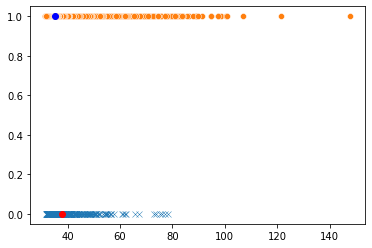

In [60]:
anom_y = np.zeros(len(anom_gs))
clean_y = np.zeros(len(clean_gs))

sns.scatterplot(x=results_anom, y=[0] * len(anom_y), marker='x')
sns.scatterplot(x=results_clean, y=[1] * len(clean_y), marker='o')
plt.scatter([np.median(results_anom)], 0, c='red')
plt.scatter([np.median(results_clean)], 1, c='blue')

<AxesSubplot:ylabel='Count'>

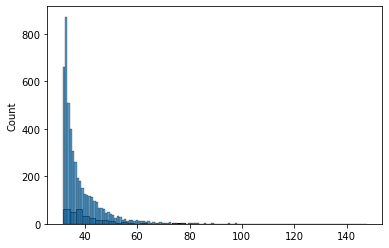

In [91]:
sns.histplot(results_anom)
sns.histplot(results_clean, ax=plt.gca())

In [61]:
results = np.column_stack((np.array(results_clean + results_anom), np.zeros(len(ego_gs))))

In [62]:
labels = []
labels +=  [0] * len(results_clean) + [1] * len(results_anom)

# pyOD

https://pyod.readthedocs.io/en/latest/index.html

In [63]:
from pyod.models.suod import SUOD
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.anogan import AnoGAN
from pyod.models.cblof import CBLOF
from pyod.models.deep_svdd import DeepSVDD
from pyod.models.iforest import IForest
from pyod.models.lof import LOF
from pyod.models.cof import COF
from pyod.models.gmm import GMM
from pyod.models.hbos import HBOS
from pyod.models.inne import INNE
from pyod.models.copod import COPOD
from pyod.models.knn import KNN
from pyod.models.lmdd import LMDD
from pyod.models.ocsvm import OCSVM
from pyod.models.mad import MAD
from pyod.models.pca import PCA
from pyod.models.so_gaal import SO_GAAL
from pyod.models.xgbod import XGBOD
from pyod.models.kde import KDE

from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize

import torch
from torch.nn import MSELoss

In [64]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(results, labels, test_size=0.33, random_state=42)

In [ ]:
# # DeepSVDD(), DeepSVDD(use_ae=True), AnoGAN(), AutoEncoder()
# detector_list = [
#     LOF(n_neighbors=20), 
#     IForest(n_estimators=100), 
#     # GMM(), 
#     # KNN(), 
#     # HBOS(), 
#     # INNE(), 
#     # COPOD(), 
#     # LOF(),
# ]

# # decide the number of parallel process, and the combination method
# # then clf can be used as any outlier detection model
# clf = SUOD(base_estimators=detector_list, n_jobs=2, combination='average',
#            verbose=False)

# clf.fit(X_train, y_train)

In [ ]:
# # get the prediction labels and outlier scores of the training data
# y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
# y_train_scores = clf.decision_scores_  # raw outlier scores

# # get the prediction on the test data
# y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
# y_test_scores = clf.decision_function(X_test)  # outlier scores

# # evaluate and print the results
# print("\nOn Training Data:")
# evaluate_print('SUOD', y_train, y_train_scores)
# print("\nOn Test Data:")
# evaluate_print('SUOD', y_test, y_test_scores)

# # visualize the results
# visualize('SUOD', X_train, y_train, X_test, y_test, y_train_pred,
#           y_test_pred, show_figure=True, save_figure=False)

# XGBOD

[15:58:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:58:58] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

On Training Data:
XGBOD ROC:0.7957, precision @ rank n:0.3298

On Test Data:
XGBOD ROC:0.6351, precision @ rank n:0.1087


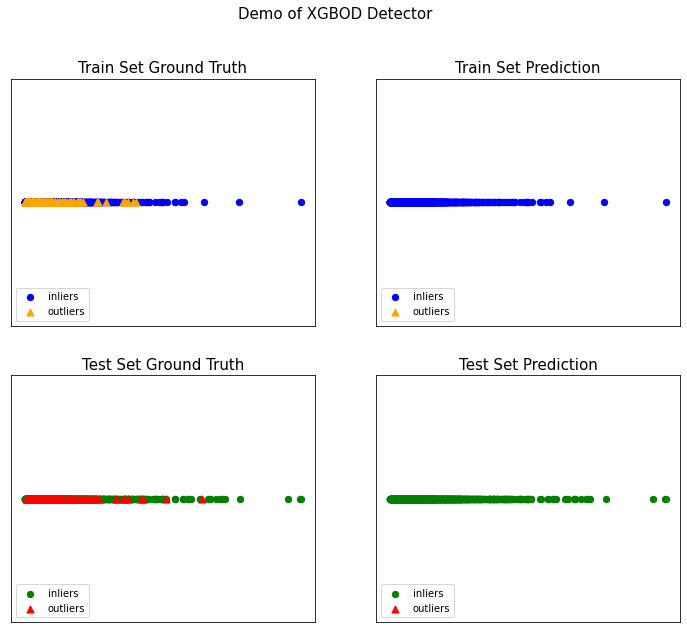

In [65]:
clf = XGBOD(estimator_list=[IForest()])
clf.fit(X_train, y_train)

# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores

# evaluate and print the results
print("\nOn Training Data:")
evaluate_print('XGBOD', y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print('XGBOD', y_test, y_test_scores)

# visualize the results
visualize('XGBOD', X_train, y_train, X_test, y_test, y_train_pred,
          y_test_pred, show_figure=True, save_figure=False)

In [66]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1621
           1       0.00      0.00      0.00        94

    accuracy                           0.95      1715
   macro avg       0.47      0.50      0.49      1715
weighted avg       0.89      0.95      0.92      1715



In [67]:
# Only report results for the class specified by pos_label (1)

print('F1:', f1_score(y_test, y_test_pred))
print('ROC-AUC:', roc_auc_score(y_test, y_test_scores))

F1: 0.0
ROC-AUC: 0.6350919448199824


Text(0, 0.5, 'True Positive Rate')

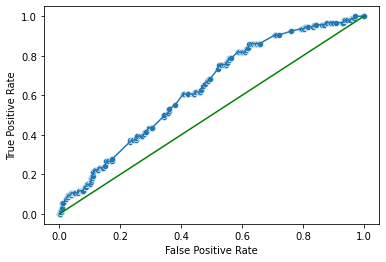

In [68]:
fpr, tpr, _ = roc_curve(y_test, y_test_scores)

sns.scatterplot(x = fpr, y = tpr)
sns.lineplot(x = fpr, y = tpr)
sns.lineplot(x = [0, 1], y = [0, 1], color = 'green')
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

## KNN


On Training Data:
KNN ROC:0.602, precision @ rank n:0.0735

On Test Data:
KNN ROC:0.6012, precision @ rank n:0.0957


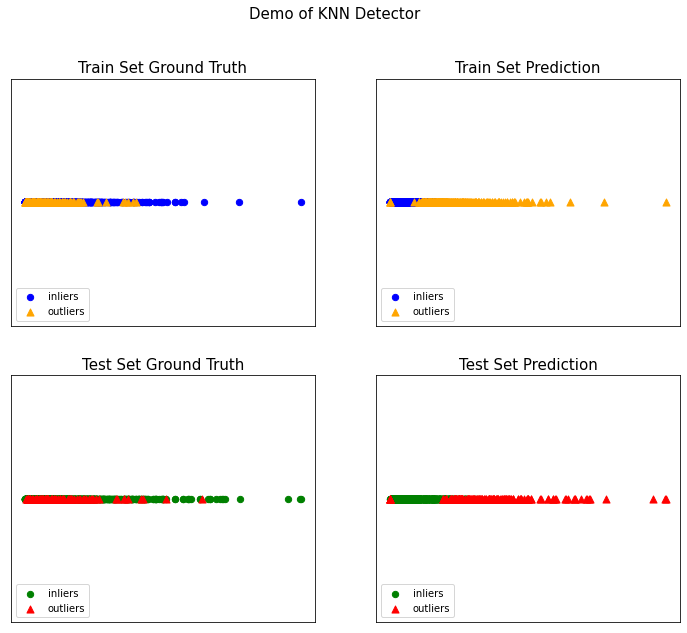

In [69]:
clf = KNN() 
clf.fit(X_train, y_train)

# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores

# evaluate and print the results
print("\nOn Training Data:")
evaluate_print('KNN', y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print('KNN', y_test, y_test_scores)

# visualize the results
visualize('KNN', X_train, y_train, X_test, y_test, y_train_pred,
          y_test_pred, show_figure=True, save_figure=False)

In [70]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.95      0.89      0.92      1621
           1       0.07      0.15      0.10        94

    accuracy                           0.85      1715
   macro avg       0.51      0.52      0.51      1715
weighted avg       0.90      0.85      0.87      1715



In [71]:
# Only report results for the class specified by pos_label (1)

print('F1:', f1_score(y_test, y_test_pred))
print('ROC-AUC:', roc_auc_score(y_test, y_test_scores))

F1: 0.0958904109589041
ROC-AUC: 0.6012114927743579


Text(0, 0.5, 'True Positive Rate')

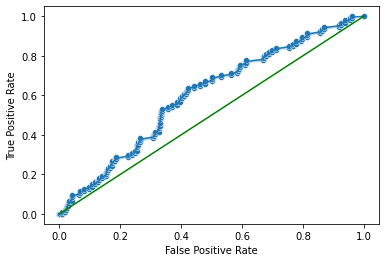

In [72]:
fpr, tpr, _ = roc_curve(y_test, y_test_scores)

sns.scatterplot(x = fpr, y = tpr)
sns.lineplot(x = fpr, y = tpr)
sns.lineplot(x = [0, 1], y = [0, 1], color = 'green')
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

# Decision Tree Classifier

In [73]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(criterion="gini", random_state=42,max_depth=3, min_samples_leaf=5)   

In [74]:
clf.fit(X_train, y_train)

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)

# Only report results for the class specified by pos_label (1)
print('F1:', f1_score(y_test, y_test_pred))
print('ROC-AUC:', roc_auc_score(y_test, y_test_pred))

F1: 0.0
ROC-AUC: 0.5


In [75]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1621
           1       0.00      0.00      0.00        94

    accuracy                           0.95      1715
   macro avg       0.47      0.50      0.49      1715
weighted avg       0.89      0.95      0.92      1715



In [176]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()

In [177]:
clf.fit(X_train, y_train)

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)

# Only report results for the class specified by pos_label (1)
print('F1:', f1_score(y_test, y_test_pred))
print('ROC-AUC:', roc_auc_score(y_test, y_test_pred))

F1: 0.9182430266110932
ROC-AUC: 0.5449350649350649


In [178]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.21      0.16      0.18       175
           1       0.91      0.93      0.92      1540

    accuracy                           0.85      1715
   macro avg       0.56      0.54      0.55      1715
weighted avg       0.84      0.85      0.84      1715



# KDE


On Training Data:
KDE ROC:0.7575, precision @ rank n:0.9198

On Test Data:
KDE ROC:0.777, precision @ rank n:0.9123


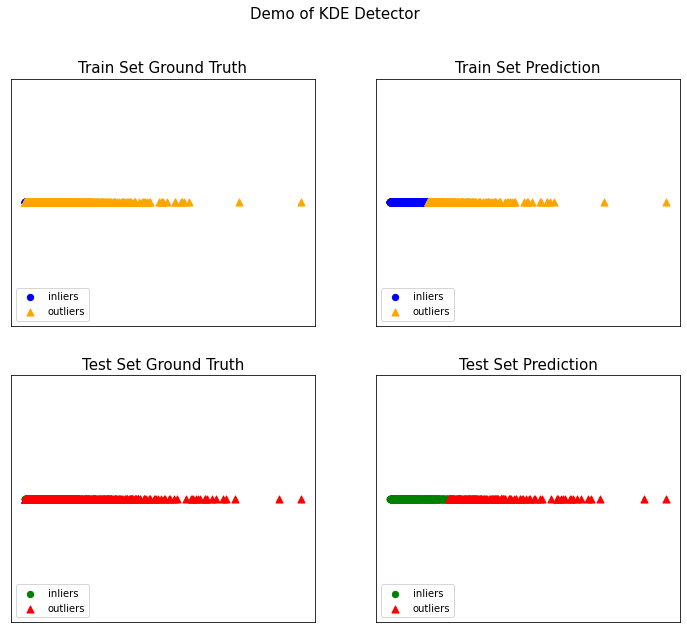

In [179]:
clf = KDE(algorithm='auto')
clf.fit(X_train, y_train)

# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores

# evaluate and print the results
print("\nOn Training Data:")
evaluate_print('KDE', y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print('KDE', y_test, y_test_scores)

# visualize the results
visualize('KDE', X_train, y_train, X_test, y_test, y_train_pred,
          y_test_pred, show_figure=True, save_figure=False)

In [180]:
# Only report results for the class specified by pos_label (1)
print('F1:', f1_score(y_test, y_test_pred))
print('ROC-AUC:', roc_auc_score(y_test, y_test_scores))

F1: 0.2319173363949483
ROC-AUC: 0.7769833024118739


In [181]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.12      1.00      0.21       175
           1       1.00      0.13      0.23      1540

    accuracy                           0.22      1715
   macro avg       0.56      0.57      0.22      1715
weighted avg       0.91      0.22      0.23      1715



Text(0, 0.5, 'True Positive Rate')

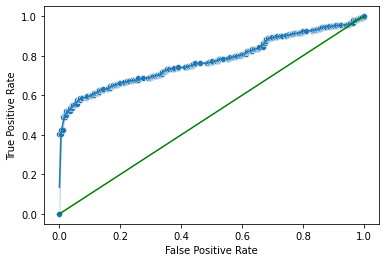

In [94]:
fpr, tpr, _ = roc_curve(y_test, y_test_scores)

sns.scatterplot(x = fpr, y = tpr)
sns.lineplot(x = fpr, y = tpr)
sns.lineplot(x = [0, 1], y = [0, 1], color = 'green')
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

# CBLOF


On Training Data:
CBLOF ROC:0.6084, precision @ rank n:0.9142

On Test Data:
CBLOF ROC:0.6253, precision @ rank n:0.8961


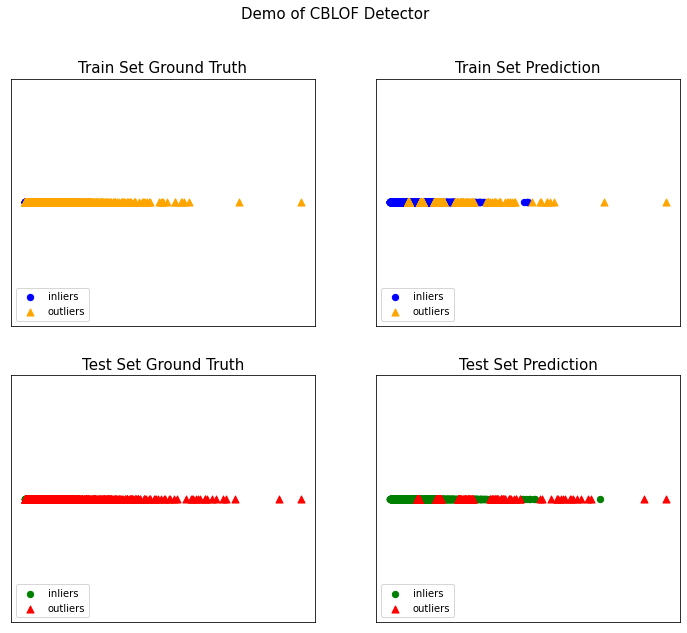

In [182]:
clf = CBLOF()
clf.fit(X_train, y_train)

# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores

# evaluate and print the results
print("\nOn Training Data:")
evaluate_print('CBLOF', y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print('CBLOF', y_test, y_test_scores)

# visualize the results
visualize('CBLOF', X_train, y_train, X_test, y_test, y_train_pred,
          y_test_pred, show_figure=True, save_figure=False)

In [183]:
# Only report results for the class specified by pos_label (1)
print('F1:', f1_score(y_test, y_test_pred))
print('ROC-AUC:', roc_auc_score(y_test, y_test_scores))

F1: 0.23495702005730656
ROC-AUC: 0.6253061224489795


In [184]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.12      1.00      0.21       175
           1       1.00      0.13      0.23      1540

    accuracy                           0.22      1715
   macro avg       0.56      0.57      0.22      1715
weighted avg       0.91      0.22      0.23      1715



Text(0, 0.5, 'True Positive Rate')

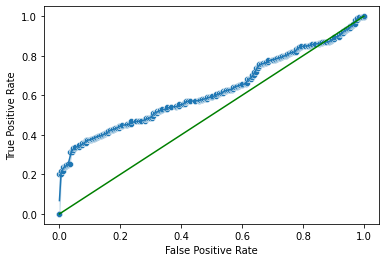

In [97]:
fpr, tpr, _ = roc_curve(y_test, y_test_scores)

sns.scatterplot(x = fpr, y = tpr)
sns.lineplot(x = fpr, y = tpr)
sns.lineplot(x = [0, 1], y = [0, 1], color = 'green')
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

# GMM


On Training Data:
CBLOF ROC:0.3522, precision @ rank n:0.9057

On Test Data:
CBLOF ROC:0.3676, precision @ rank n:0.8877


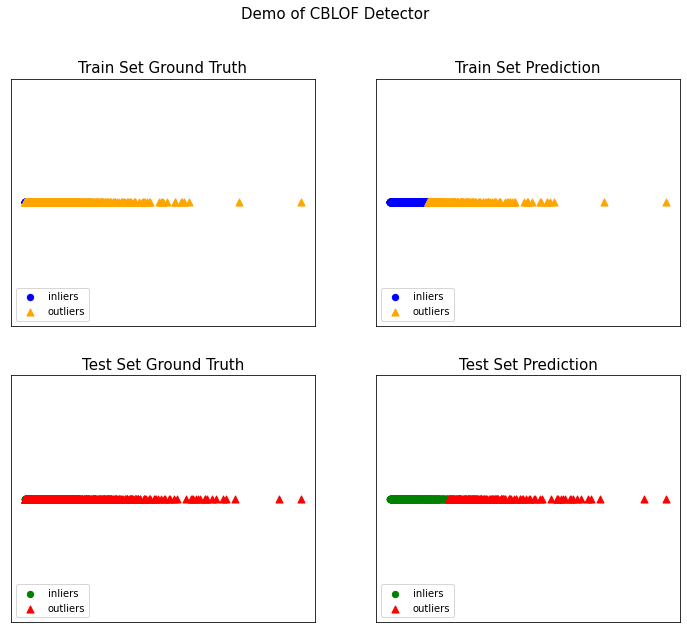

In [185]:
clf = GMM()
clf.fit(X_train, y_train)

# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores

# evaluate and print the results
print("\nOn Training Data:")
evaluate_print('CBLOF', y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print('CBLOF', y_test, y_test_scores)

# visualize the results
visualize('CBLOF', X_train, y_train, X_test, y_test, y_train_pred,
          y_test_pred, show_figure=True, save_figure=False)

In [186]:
# Only report results for the class specified by pos_label (1)
print('F1:', f1_score(y_test, y_test_pred))
print('ROC-AUC:', roc_auc_score(y_test, y_test_scores))

F1: 0.2319173363949483
ROC-AUC: 0.3675732838589981


In [187]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.12      1.00      0.21       175
           1       1.00      0.13      0.23      1540

    accuracy                           0.22      1715
   macro avg       0.56      0.57      0.22      1715
weighted avg       0.91      0.22      0.23      1715



Text(0, 0.5, 'True Positive Rate')

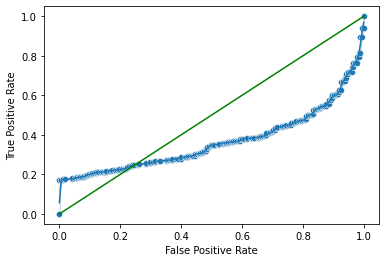

In [100]:
fpr, tpr, _ = roc_curve(y_test, y_test_scores)

sns.scatterplot(x = fpr, y = tpr)
sns.lineplot(x = fpr, y = tpr)
sns.lineplot(x = [0, 1], y = [0, 1], color = 'green')
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

## Score Generation

Extracting node anomalies from group anomalies

In [137]:
# scores = []
# for idx, g in enumerate(tqdm(ego_gs)):
#     score = 0
#     for node in g.nodes:
#         score += anom_scores[node]
#     scores.append(score / len(g.nodes))

scores = []
for idx, key in enumerate(tqdm(anom_scores)):
    score = sum(anom_scores[key]) / len(anom_scores[key])
    scores.append([1-score, score])
#     scores.append(score)
    
scores = np.array(scores)

  0%|          | 0/5196 [00:00<?, ?it/s]

## Message Passing

In [8]:
# create edge index from 
adj = nx.to_scipy_sparse_array(G).tocoo()
row = torch.from_numpy(adj.row.astype(np.int64)).to(torch.long)
col = torch.from_numpy(adj.col.astype(np.int64)).to(torch.long)
edge_index = torch.stack([row, col], dim=0)

AttributeError: module 'scipy.sparse' has no attribute 'coo_array'

In [19]:
anom_vals = []
for idx, label in enumerate(labels):
    if label == 1:
        anom_vals.append(scores[idx])

print(np.unique(anom_vals, return_counts=True))

(array([1.]), array([298]))


In [20]:
from sklearn.preprocessing import StandardScaler

scale = StandardScaler()
embeddings = scale.fit_transform(np.array(scores).reshape(-1, 1))

In [22]:
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
from torch_geometric.data import InMemoryDataset, Data

from sklearn.model_selection import train_test_split

OSError: /home/tutt/miniconda3/envs/anom_detect/lib/python3.10/site-packages/torch_sparse/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE

In [548]:
class BlogCatalogDataset(InMemoryDataset):
    def __init__(self, transform=None):
        super(BlogCatalogDataset, self).__init__('.', transform, None, None)

        data = Data(edge_index=edge_index)
        
        data.num_nodes = G.number_of_nodes()
        
        # embedding 
        data.x = torch.from_numpy(embeddings).type(torch.float32)
        
        # labels
        y = torch.from_numpy(np.array(labels)).type(torch.long)
        data.y = y.clone().detach()
        
        data.num_classes = 2

        # splitting the data into train, validation and test
        X_train, X_test, y_train, y_test = train_test_split(pd.Series(list(G.nodes())), 
                                                            pd.Series(labels),
                                                            test_size=0.30, 
                                                            random_state=42)
        
        n_nodes = G.number_of_nodes()
        
        # create train and test masks for data
        train_mask = torch.zeros(n_nodes, dtype=torch.bool)
        test_mask = torch.zeros(n_nodes, dtype=torch.bool)
        train_mask[X_train.index] = True
        test_mask[X_test.index] = True
        data['train_mask'] = train_mask
        data['test_mask'] = test_mask

        self.data, self.slices = self.collate([data])

    def _download(self):
        return

    def _process(self):
        return

    def __repr__(self):
        return '{}()'.format(self.__class__.__name__)

In [564]:
class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(GCNConv, self).__init__(aggr='add')  # "Add" aggregation
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        # Step 1: Add self-loops
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Multiply with weights
        x = self.lin(x)

        # Step 3: Calculate the normalization
        row, col = edge_index
        deg = degree(row, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4: Propagate the embeddings to the next layer
        return self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x,
                              norm=norm)

    def message(self, x_j, norm):
        # Normalize node features.
        return norm.view(-1, 1) * x_j
    

class Net(torch.nn.Module):
    def __init__(self, dataset):
        super(Net, self).__init__()
#         self.conv1 = GCNConv(dataset.num_node_features, 16)
#         self.conv2 = GCNConv(16, dataset.num_classes)


        self.conv1 = GCNConv(dataset.num_node_features, dataset.num_classes)


    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        x = self.conv1(x, edge_index)
#         x = F.relu(x)
#         x = F.dropout(x, training=self.training)
#         x = self.conv2(x, edge_index)
        print(x)
        print(F.softmax(x, dim=1))
        
        return F.softmax(x, dim=1)

In [565]:
def test(data, train=True):
    model.eval()

    correct = 0
    pred = model(data).max(dim=1)[1]
    
#     print(np.unique(pred[data.train_mask].cpu().numpy()))
    
#     if not train:
#         print(f1_score(data.y[data.train_mask].cpu().numpy(), pred[data.train_mask].cpu().numpy()))

    if train:
        correct += pred[data.train_mask].eq(data.y[data.train_mask]).sum().item()
        return correct / (len(data.y[data.train_mask]))
    else:
        correct += pred[data.test_mask].eq(data.y[data.test_mask]).sum().item()
        return correct / (len(data.y[data.test_mask]))


In [566]:
def train(data, epochs=100, plot=False):
    train_accuracies, test_accuracies = list(), list()
    for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()
            out = model(data)
            loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            train_acc = test(data)
            test_acc = test(data, train=False)         

            train_accuracies.append(train_acc)
            test_accuracies.append(test_acc)
            print('Epoch: {:03d}, Loss: {:.5f}, Train Acc: {:.5f}, Test Acc: {:.5f}'.
                  format(epoch, loss, train_acc, test_acc))

    if plot:
        plt.plot(train_accuracies, label="Train accuracy")
        plt.plot(test_accuracies, label="Validation accuracy")
        plt.xlabel("# Epoch")
        plt.ylabel("Accuracy")
        plt.legend(loc='upper right')
        plt.show()

In [567]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dataset = BlogCatalogDataset()

model = Net(dataset).to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

train(data, epochs=1, plot=False)

tensor([[-3.3398,  1.7935],
        [-2.5713,  1.4916],
        [-2.3944,  1.5148],
        ...,
        [-0.3018,  0.6146],
        [-0.4743,  0.2855],
        [-0.1900,  0.4870]], device='cuda:0', grad_fn=<ScatterAddBackward0>)
tensor([[0.0059, 0.9941],
        [0.0169, 0.9831],
        [0.0197, 0.9803],
        ...,
        [0.2857, 0.7143],
        [0.3187, 0.6813],
        [0.3369, 0.6631]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([[-3.3180,  1.7716],
        [-2.5524,  1.4726],
        [-2.3743,  1.4947],
        ...,
        [-0.2911,  0.6039],
        [-0.4706,  0.2818],
        [-0.1814,  0.4784]], device='cuda:0', grad_fn=<ScatterAddBackward0>)
tensor([[0.0061, 0.9939],
        [0.0176, 0.9824],
        [0.0205, 0.9795],
        ...,
        [0.2901, 0.7099],
        [0.3203, 0.6797],
        [0.3408, 0.6592]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([[-3.3180,  1.7716],
        [-2.5524,  1.4726],
        [-2.3743,  1.4947],
        ...,
        [-0.2

In [568]:
test(data, train=False)

tensor([[-3.3180,  1.7716],
        [-2.5524,  1.4726],
        [-2.3743,  1.4947],
        ...,
        [-0.2911,  0.6039],
        [-0.4706,  0.2818],
        [-0.1814,  0.4784]], device='cuda:0', grad_fn=<ScatterAddBackward0>)
tensor([[0.0061, 0.9939],
        [0.0176, 0.9824],
        [0.0205, 0.9795],
        ...,
        [0.2901, 0.7099],
        [0.3203, 0.6797],
        [0.3408, 0.6592]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


0.055805003207184095

In [554]:
pred = model(data)[data.test_mask].detach().cpu().numpy()
true_y = data.y[data.test_mask].detach().cpu().numpy()

In [555]:
f1_score(true_y, np.argmax(pred, axis=1))

0.035928143712574856

In [556]:
roc_auc_score(true_y, np.argmax(pred, axis=1))

0.491086488005997

In [557]:
np.unique(np.argmax(pred, axis=1))

array([0, 1])

## Belief Propogation

In [162]:
from scipy.sparse import (csr_matrix,
                          issparse)

In [163]:
scores = scores.reshape(-1, 1)

In [164]:
# adjusted for homophily
H = np.flip(create_parameterized_H(2, 8, symmetric=True), axis=1)

W = csr_matrix(np.ones((len(scores), len(scores))))

X = scores

In [165]:
from SSLH_inference import *

In [167]:
out = linBP_symmetric(X, W, H)

AssertionError: 

In [142]:
# pred = np.argmax(out, axis=1)

In [149]:
from sklearn.preprocessing import MinMaxScaler

scale = MinMaxScaler()
embeddings = scale.fit_transform(np.array(out))

In [157]:
roc_auc_score(labels, embeddings[:, 1])

0.9080236831359739

In [119]:
np.unique(labels, return_counts=True)

(array([0, 1]), array([4898,  298]))

In [121]:
roc_curve(labels, out)

(array([0.        , 0.18395263, 0.18599428, 0.18721927, 0.18742344,
        0.18783177, 0.18803593, 0.18926092, 0.19007758, 0.19130257,
        0.19150674, 0.19273173, 0.19314006, 0.19416088, 0.19518171,
        0.19599837, 0.19620253, 0.19701919, 0.19804002, 0.19844835,
        0.19906084, 0.20008167, 0.20069416, 0.20171499, 0.20253165,
        0.20314414, 0.20334831, 0.20436913, 0.2045733 , 0.20538996,
        0.20661494, 0.20824826, 0.20988158, 0.21028991, 0.21131074,
        0.2115149 , 0.21233156, 0.21335239, 0.21376072, 0.21539404,
        0.2162107 , 0.21743569, 0.21866068, 0.21886484, 0.220294  ,
        0.22131482, 0.22151899, 0.22294814, 0.22519396, 0.22539812,
        0.22641895, 0.22682728, 0.22703144, 0.22886893, 0.23091058,
        0.23336056, 0.23376889, 0.23560637, 0.2360147 , 0.23907717,
        0.23928134, 0.24091466, 0.24111882, 0.24397713, 0.2441813 ,
        0.24703961, 0.24744794, 0.24969375, 0.25010208, 0.25479788,
        0.25500204, 0.25541037, 0.25561454, 0.25

In [122]:
out

array([[ 1.27290819e+35],
       [ 1.95891216e+34],
       [ 2.73710547e+34],
       ...,
       [-2.84807083e+35],
       [ 6.11564061e+35],
       [-8.98113654e+35]])

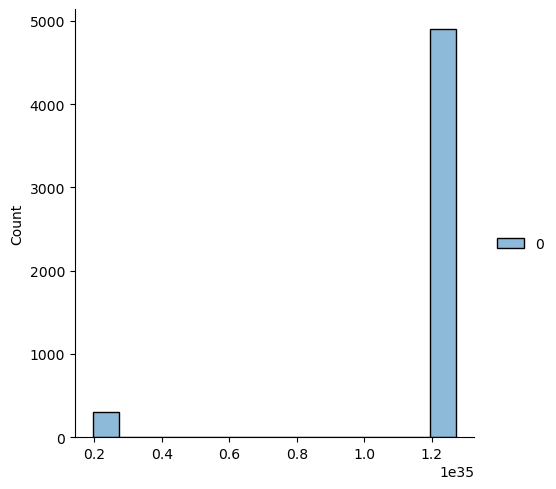

In [129]:
sns.displot(out[labels])

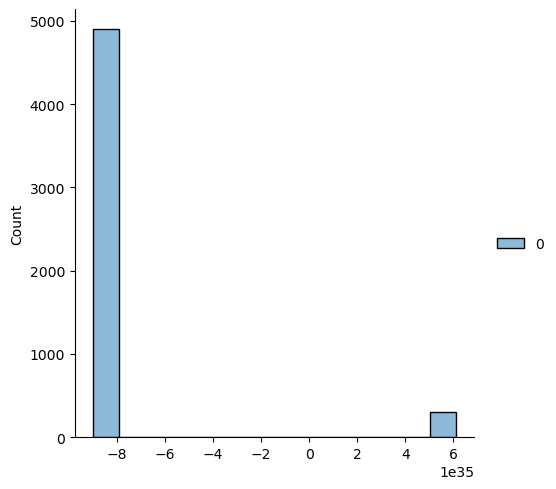

In [131]:
sns.displot(out[~np.array(labels)])

In [136]:
create_parameterized_H(1, 8, symmetric=True)

array([[1.]])

# Clustering -> Scoring -> BP

In [239]:
G, ego_gs, labels, roots = load_network('datasets/ACM.mat')

labels = [int(l) for l in labels]

print(f'Using {len(ego_gs)} egonets')

Graph with 16484 nodes and 90557 edges


  0%|          | 0/16445 [00:00<?, ?it/s]

Using 16445 egonets


In [240]:
slice_size = int(input("Input a slice size for tensor: "))

Input a slice size for tensor: 1000


In [ ]:
padded_gs = []
for gs in tqdm(ego_gs):
    g = nx.to_numpy_array(gs)
    padded = np.zeros((slice_size, slice_size))
    if len(padded) >= len(g):
        padded[:g.shape[0], :g.shape[1]] = g
    else:
        padded = g[:slice_size, :slice_size]
    padded_gs.append(padded)

  0%|          | 0/16445 [00:00<?, ?it/s]

In [ ]:
with open(input('Enter file path: '), 'rb') as f:
    factors = pickle.load(f)
    f.close()

A, B, C = factors
A, B, C, = np.array(A), np.array(B), np.array(C)

In [ ]:
errors = []
for gs in tqdm(padded_gs):
    gs_p = (A @ ((A.T @ gs) @ B) @ B.T)
    d = np.linalg.norm(gs - gs_p)
    errors.append(d)

In [ ]:
errors = np.array(errors).reshape(-1, 1)

In [ ]:
from pyod.models.suod import SUOD
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.anogan import AnoGAN
from pyod.models.cblof import CBLOF
from pyod.models.deep_svdd import DeepSVDD
from pyod.models.iforest import IForest
from pyod.models.lof import LOF
from pyod.models.cof import COF
from pyod.models.gmm import GMM
from pyod.models.hbos import HBOS
from pyod.models.inne import INNE
from pyod.models.copod import COPOD
from pyod.models.knn import KNN
from pyod.models.lmdd import LMDD
from pyod.models.ocsvm import OCSVM
from pyod.models.mad import MAD
from pyod.models.pca import PCA
from pyod.models.so_gaal import SO_GAAL
from pyod.models.xgbod import XGBOD
from pyod.models.kde import KDE

from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize

In [ ]:
clf = KDE(algorithm='auto')

In [ ]:
clf.fit(errors)

# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# evaluate and print the results
print("\nOn Data:")
evaluate_print('KDE', labels, y_train_scores)

In [ ]:
y_train_pred

In [ ]:
# given y pred, generate scores for BP

anom_scores = dict()

# for idx, g in enumerate(tqdm(ego_gs)):
#     anom_scores[idx] = []

for idx, node in enumerate(tqdm(G.nodes())):
    # check if root is anomalous first
    label = y_train_pred[idx]
    
    anom_scores[node] = label

In [ ]:
scores = []
for idx, g in enumerate(tqdm(ego_gs)):
    score = 0
    for node in g.nodes:
        score += anom_scores[node]
    scores.append(score / len(g.nodes))

In [ ]:
from scipy.sparse import (csr_matrix,
                          issparse)

In [ ]:
from SSLH_inference import *
from SSLH_utils import create_parameterized_H

In [ ]:
scores = np.array(scores).reshape(-1, 1)

In [ ]:
# adjusted for homophily
H = np.flip(create_parameterized_H(1, 5, symmetric=True), axis=1)

W = csr_matrix(np.ones((len(scores), len(scores))))

X = scores

In [ ]:
out = linBP_symmetric(X, W, H)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scale = MinMaxScaler()
embeddings = scale.fit_transform(np.array(out))

In [ ]:
roc_auc_score(labels, embeddings)

In [ ]:
1 - roc_auc_score(labels, embeddings)